In [3]:
import pandas as pd
import altair as alt

from datetime import timedelta
import pytz

import sys
sys.path.append('../')
from mod import load_data, alt_theme

In [4]:
comments, issues, prs = load_data('../../data/')
bot_names = pd.read_csv('../bot_names.csv')
comments = comments.query('author not in @bot_names')
issues = issues.query('author not in @bot_names')
prs = prs.query('author not in @bot_names')

In [5]:
renderer = "jupyterlab"

In [6]:
alt.renderers.enable(renderer);
alt.themes.register('my_theme', alt_theme)
alt.themes.enable("my_theme")

ThemeRegistry.enable('my_theme')

In [7]:
use_data = prs  # comments
seen_times = use_data.groupby(['org', 'author']).agg({'updatedAt': ['min', 'max']})['updatedAt']

In [4]:
seen_times = seen_times.rename(columns={'min': 'first_seen', 'max': 'last_seen'})
for col in seen_times.columns:
    seen_times[col] = pd.to_datetime(seen_times[col], utc=True)

/home/choldgraf/anaconda/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



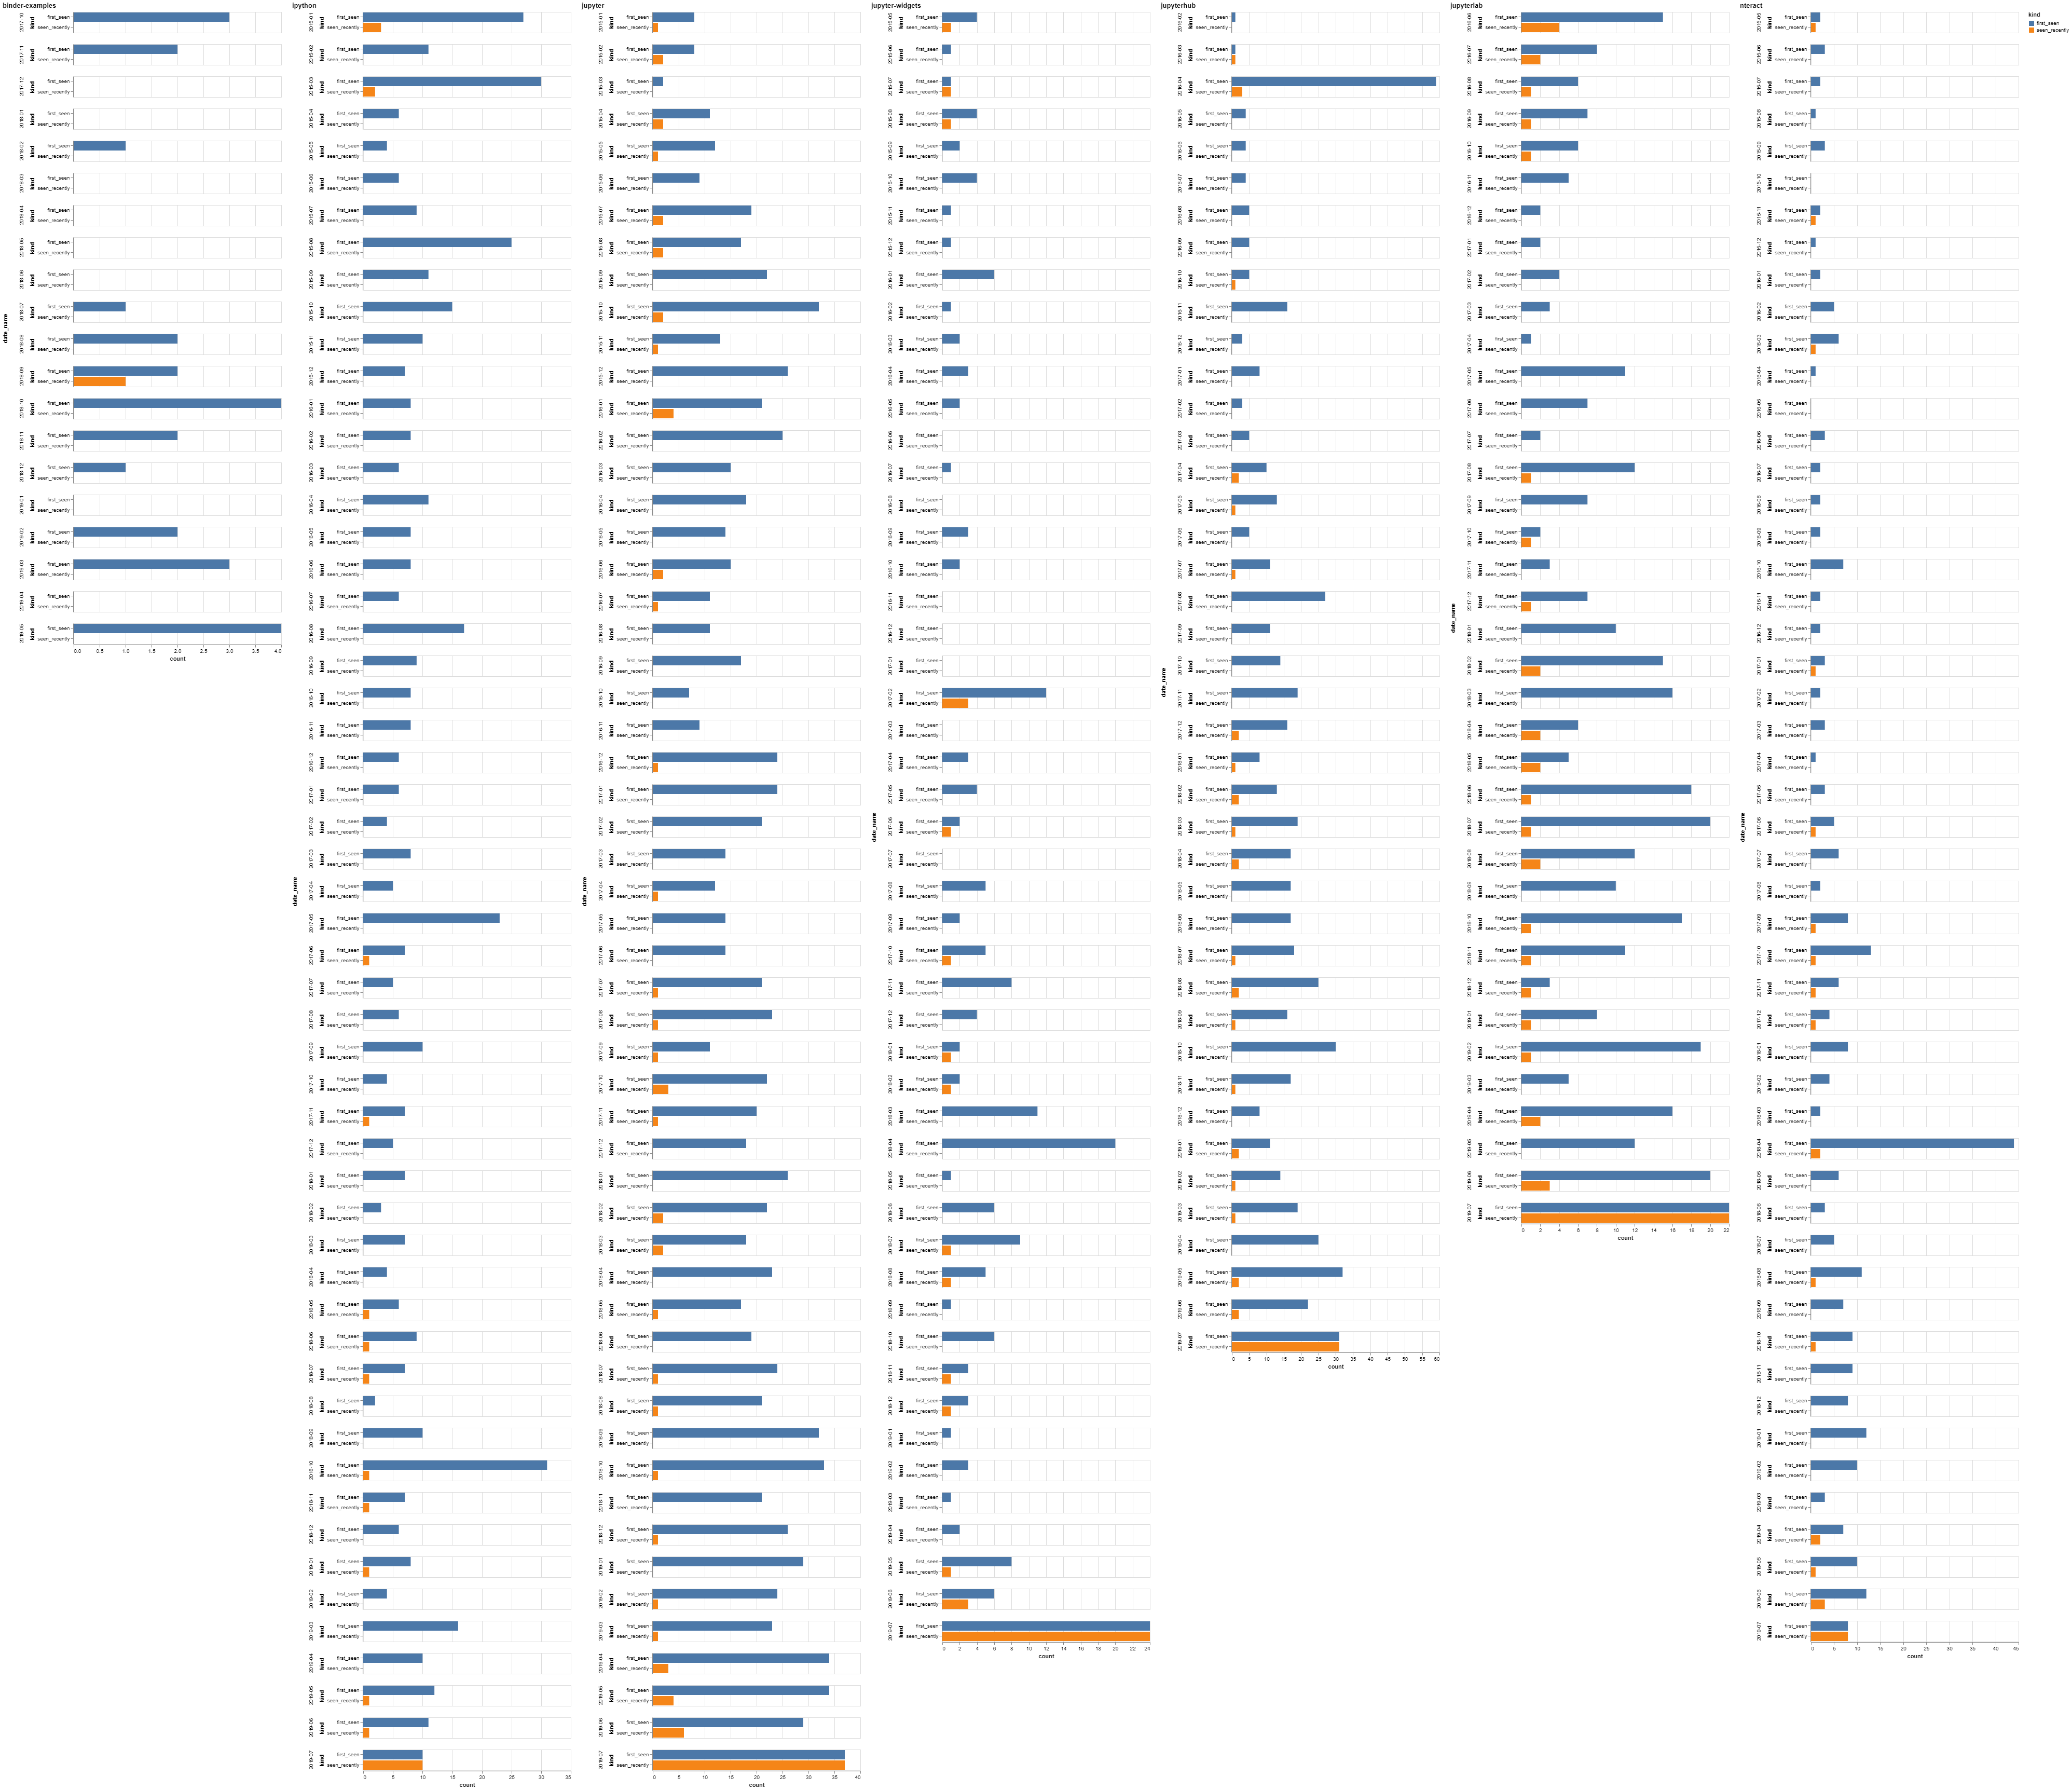

In [5]:
# "recent" defined as N days in the past
recently = pd.datetime.utcnow() - timedelta(days=30)
recently = pytz.utc.localize(recently)

charts = []
for org, idata in seen_times.groupby('org'):
    idata = idata.loc[org]

    idata['seen_recently'] = idata.eval('last_seen > @recently')


    first_seen = idata.resample('M', on='first_seen').agg({'first_seen': 'count', 'seen_recently': 'sum'})
    first_seen.index.name = 'date'

    first_seen = pd.melt(first_seen.reset_index(), id_vars='date', var_name='kind', value_name='count')

    first_seen['date_name'] = first_seen['date'].map(lambda a: "{:%Y-%m}".format(a))

    bar = alt.Chart(first_seen, title=org).mark_bar().encode(
        x='count:Q',
        y='kind',
        color='kind',
        row='date_name:O'
    )
    charts.append(bar)
    
alt.hconcat(*charts)

In [ ]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>